In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve
from itertools import combinations
from statsmodels.genmod.families import Binomial

In [2]:
# Load the raw dataset
df = pd.read_csv("meyer.csv")
print("Initial DataFrame shape:", df.shape)
df.head()

Initial DataFrame shape: (243, 15)


,moisture,spring_stiffness,displacement_screw_setting,motor_speed,untouched,longitudinal less than 25%,Longitudinal between 25-50%,Longitudinal between 50-75%,Longitudinal more than 75%,Circumferential less than 25%,Circumferential between 25-50%,Circumferential between 50-75%,Circumferential more than 75%,Open Crack,Crushed
0,5,1800,0.29,60,NaN,NaN,NaN,NaN,"*GH013810, *GH013811, *GH013812, *GH013813, *G...",NaN,"*GH013812, *GH013813, *GH013814",NaN,"*GH013810, *GH013811, *GH013815","*GH013810, *GH013811, *GH013812, *GH013813, *G...",NaN
1,5,1800,0.22,45,NaN,NaN,NaN,NaN,"*GH013816, *GH013817, *GH013818, *GH013819, *G...",NaN,*GH013818,*GH013821,"*GH013816, *GH013817, *GH013819, *GH013820","*GH013816, *GH013817, *GH013818, *GH013819, *G...",NaN
2,5,1800,0.36,30,*GH013822,NaN,NaN,*GH013823,"*GH013824, *GH013825, *GH013826, *GH013827","*GH013823, *GH013826",NaN,"*GH013824, *GH013827",*GH013825,"*GH013823, *GH013824, *GH013825, *GH013827",NaN
3,5,1800,0.36,60,*GH013832,NaN,NaN,NaN,"*GH013828, *GH013829, *GH013830, *GH013831, *G...",*GH013829,"*GH013830, *GH013833",*GH013828,*GH013831,"*GH013828, *GH013830, *GH013831, *GH013833",NaN
4,5,1800,0.22,30,NaN,NaN,NaN,NaN,"*GH013834, *GH013835, *GH013836, *GH013837, *G...",NaN,NaN,*GH013836,"*GH013834, *GH013835, *GH013837, *GH013838, *G...","*GH013834, *GH013835, *GH013836, *GH013837, *G...",NaN


In [3]:
# Standardize column names
df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_").str.replace("-", "_")
print("Renamed columns:", df.columns.tolist())

Renamed columns: ['moisture', 'spring_stiffness', 'displacement_screw_setting', 'motor_speed', 'untouched', 'longitudinal_less_than_25%', 'longitudinal_between_25_50%', 'longitudinal_between_50_75%', 'longitudinal_more_than_75%', 'circumferential_less_than_25%', 'circumferential_between_25_50%', 'circumferential_between_50_75%', 'circumferential_more_than_75%', 'open_crack', 'crushed']


In [4]:
# Define factor columns and convert them to numeric
factor_cols = ["moisture", "spring_stiffness", "displacement_screw_setting", "motor_speed"]
for col in factor_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
print("Missing values in factor columns:")
print(df[factor_cols].isnull().sum())

Missing values in factor columns:
moisture                      0
spring_stiffness              0
displacement_screw_setting    0
motor_speed                   0
dtype: int64


In [5]:
# Identify crack outcome columns
crack_cols = [c for c in df.columns if c not in factor_cols]
print("Crack columns identified:", crack_cols)

Crack columns identified: ['untouched', 'longitudinal_less_than_25%', 'longitudinal_between_25_50%', 'longitudinal_between_50_75%', 'longitudinal_more_than_75%', 'circumferential_less_than_25%', 'circumferential_between_25_50%', 'circumferential_between_50_75%', 'circumferential_more_than_75%', 'open_crack', 'crushed']


In [6]:
# Define functions to extract video IDs from a cell and count unique video IDs across crack columns.
def extract_video_ids(cell_value: str) -> list:
    if pd.isna(cell_value):
        return []
    return [x.strip() for x in cell_value.split(",") if x.strip() != ""]


def count_unique_videos(row: pd.Series) -> int:
    all_ids = []
    for col in crack_cols:
        all_ids.extend(extract_video_ids(row[col]))
    return len(set(all_ids))

In [7]:
# Compute unique video counts for each row and flag incomplete runs
df["video_count"] = df.apply(count_unique_videos, axis=1)
df["missing_videos_flag"] = df["video_count"] < 6
print(df[["video_count", "missing_videos_flag"]].head(10))
print(f"Number of runs with fewer than 6 videos: {df['missing_videos_flag'].sum()}")

   video_count  missing_videos_flag
0            6                False
1            6                False
2            6                False
3            6                False
4            6                False
5            5                 True
6            6                False
7            6                False
8            6                False
9            6                False
Number of runs with fewer than 6 videos: 16


In [8]:
# Verify that factor columns contain the expected values.

# %%
print("Motor Speed values:", df["motor_speed"].unique())  # Expected: [30, 45, 60]
print("Moisture values:", df["moisture"].unique())  # Expected: [5, 7, 9]
print("Displacement Screw Setting values:", df["displacement_screw_setting"].unique())  # Expected: [0.22, 0.29, 0.36]
print("Spring Stiffness values:", df["spring_stiffness"].unique())  # Expected: [1800, 2000, 2200]

Motor Speed values: [60 45 30]
Moisture values: [5 7 9]
Displacement Screw Setting values: [0.29 0.22 0.36]
Spring Stiffness values: [1800 2000 2200]


In [9]:
# Create long-format records: one row per video ID with its corresponding factor values and crack type.
records = []
for idx, row in df.iterrows():
    # Extract factor values for the run
    factors = {col: row[col] for col in factor_cols}
    # Iterate through each crack outcome column and extract video IDs
    for col in crack_cols:
        video_ids = extract_video_ids(row[col])
        for vid in video_ids:
            record = factors.copy()
            record["video_id"] = vid
            record["crack_type"] = col  # Original crack category name
            records.append(record)

df_long = pd.DataFrame(records)
print("Long-format DataFrame shape:", df_long.shape)
df_long.head(10)

Long-format DataFrame shape: (3769, 6)


,moisture,spring_stiffness,displacement_screw_setting,motor_speed,video_id,crack_type
0,5,1800,0.29,60,*GH013810,longitudinal_more_than_75%
1,5,1800,0.29,60,*GH013811,longitudinal_more_than_75%
2,5,1800,0.29,60,*GH013812,longitudinal_more_than_75%
3,5,1800,0.29,60,*GH013813,longitudinal_more_than_75%
4,5,1800,0.29,60,*GH013814,longitudinal_more_than_75%
5,5,1800,0.29,60,*GH013815,longitudinal_more_than_75%
6,5,1800,0.29,60,*GH013812,circumferential_between_25_50%
7,5,1800,0.29,60,*GH013813,circumferential_between_25_50%
8,5,1800,0.29,60,*GH013814,circumferential_between_25_50%
9,5,1800,0.29,60,*GH013810,circumferential_more_than_75%


In [10]:
# Pivot the long-format data with 'video_id' and factors as the index, and crack_type as columns.
df_aggregated = df_long.pivot_table(index=["video_id", "moisture", "spring_stiffness", "displacement_screw_setting", "motor_speed"], columns="crack_type", values="crack_type", aggfunc=lambda x: 1, fill_value=0).reset_index()

# Print raw aggregated column names
print("Raw aggregated columns:", df_aggregated.columns.tolist())

Raw aggregated columns: ['video_id', 'moisture', 'spring_stiffness', 'displacement_screw_setting', 'motor_speed', 'circumferential_between_25_50%', 'circumferential_between_50_75%', 'circumferential_less_than_25%', 'circumferential_more_than_75%', 'crushed', 'longitudinal_between_25_50%', 'longitudinal_between_50_75%', 'longitudinal_less_than_25%', 'longitudinal_more_than_75%', 'open_crack', 'untouched']


In [11]:
# Expected factor names:
expected_factor_cols = ["video", "moisture", "spring", "displacement", "motor"]

# Get current aggregated columns as a list
current_cols = df_aggregated.columns.tolist()

# Replace the first five columns with our desired factor names.
for i in range(len(expected_factor_cols)):
    current_cols[i] = expected_factor_cols[i]
df_aggregated.columns = current_cols
print("After reassigning factor names:")
print(df_aggregated.columns.tolist())

# Print remaining crack outcome columns (raw)
print("Raw crack outcome columns:", df_aggregated.columns[5:])

# Define renaming dictionary for crack outcomes:
rename_dict = {"untouched": "U", "longitudinal_less_than_25%": "L_1", "longitudinal_between_25_50%": "L_2", "longitudinal_between_50_75%": "L_3", "longitudinal_more_than_75%": "L_4", "circumferential_less_than_25%": "C_1", "circumferential_between_25_50%": "C_2", "circumferential_between_50_75%": "C_3", "circumferential_more_than_75%": "C_4", "open_crack": "O", "crushed": "X"}

# Rename crack outcome columns (columns 6 onward)
new_crack_cols = [rename_dict.get(col, col) for col in df_aggregated.columns[5:]]
# Combine factor columns with renamed crack outcome columns
df_aggregated.columns = expected_factor_cols + new_crack_cols
print("Columns after renaming crack outcomes:")
print(df_aggregated.columns.tolist())

After reassigning factor names:
['video', 'moisture', 'spring', 'displacement', 'motor', 'circumferential_between_25_50%', 'circumferential_between_50_75%', 'circumferential_less_than_25%', 'circumferential_more_than_75%', 'crushed', 'longitudinal_between_25_50%', 'longitudinal_between_50_75%', 'longitudinal_less_than_25%', 'longitudinal_more_than_75%', 'open_crack', 'untouched']
Raw crack outcome columns: Index(['circumferential_between_25_50%', 'circumferential_between_50_75%',
       'circumferential_less_than_25%', 'circumferential_more_than_75%',
       'crushed', 'longitudinal_between_25_50%', 'longitudinal_between_50_75%',
       'longitudinal_less_than_25%', 'longitudinal_more_than_75%',
       'open_crack', 'untouched'],
      dtype='object')
Columns after renaming crack outcomes:
['video', 'moisture', 'spring', 'displacement', 'motor', 'C_2', 'C_3', 'C_1', 'C_4', 'X', 'L_2', 'L_3', 'L_1', 'L_4', 'O', 'U']


In [12]:
# Define desired order for crack outcome columns
desired_order = ["U", "L_1", "L_2", "L_3", "L_4", "C_1", "C_2", "C_3", "C_4", "O", "X"]
# Factor columns remain as defined
factor_order = expected_factor_cols
# Extract current crack outcome columns (from index 5 onward)
current_crack_cols = df_aggregated.columns.tolist()[5:]
# Reorder crack outcome columns based on desired order (only include those present)
new_crack_cols_ordered = [col for col in desired_order if col in current_crack_cols]
# Combine factor columns with the newly ordered crack outcome columns
new_column_order = factor_order + new_crack_cols_ordered
df_aggregated = df_aggregated[new_column_order]
print("Final aggregated binary column order:")
print(df_aggregated.columns.tolist())

Final aggregated binary column order:
['video', 'moisture', 'spring', 'displacement', 'motor', 'U', 'L_1', 'L_2', 'L_3', 'L_4', 'C_1', 'C_2', 'C_3', 'C_4', 'O', 'X']


In [13]:
# Save the final aggregated binary dataset with the desired column names to a single CSV file.
df_aggregated.to_csv("meyer_aggregated_binary_renamed.csv", index=False)
print("Final renamed aggregated binary dataset saved as 'meyer_aggregated_binary_renamed.csv'.")

Final renamed aggregated binary dataset saved as 'meyer_aggregated_binary_renamed.csv'.


In [14]:
# Load the final aggregated binary dataset
df_agg = pd.read_csv("meyer_aggregated_binary_renamed.csv")
print("Aggregated binary dataset shape:", df_agg.shape)
df_agg.head()

Aggregated binary dataset shape: (1442, 16)


,video,moisture,spring,displacement,motor,U,L_1,L_2,L_3,L_4,C_1,C_2,C_3,C_4,O,X
0,*GH012974,7,2000,0.22,30,0,0,0,0,1,0,1,0,0,1,0
1,*GH012975,7,2000,0.22,30,0,0,0,0,1,0,0,0,1,1,0
2,*GH012976,7,2000,0.22,30,0,0,0,0,1,0,0,1,0,1,0
3,*GH012977,7,2000,0.22,30,0,0,0,0,1,0,0,1,0,1,0
4,*GH012978,7,2000,0.22,30,0,0,0,0,1,0,0,0,1,1,0


In [15]:
# Define UGA-Themed Color Palette
# Each color is chosen to be visually distinct while referencing UGA reds, grays, neutrals, and black.
uga_palette = sns.color_palette(["#BA0C2F", "#D43E5C", "#E38296", "#F0BDC9", "#000000", "#404041", "#717074", "#A7A6A9", "#D7D2CB", "#EED2C0", "#F2F3F4"], n_colors=11)

# For consistent ordering in the plots, define your crack outcome columns
crack_outcome_cols = ["U", "L_1", "L_2", "L_3", "L_4", "C_1", "C_2", "C_3", "C_4", "O", "X"]

In [16]:
# Overall Frequency of Each Crack Outcome, Sum the binary columns to get counts for each crack type and calculate percentages.
# List of crack outcome columns (we know these are the factor columns are the first five)
crack_outcome_cols = ["U", "L_1", "L_2", "L_3", "L_4", "C_1", "C_2", "C_3", "C_4", "O", "X"]

# Calculate counts (i.e., number of videos with each crack type)
crack_counts = df_agg[crack_outcome_cols].sum()
print("Crack outcome counts:")
print(crack_counts)

Crack outcome counts:
U       143
L_1      16
L_2      18
L_3     164
L_4    1093
C_1     268
C_2     285
C_3     310
C_4     435
O       975
X        58
dtype: int64


In [17]:
# Calculate percentages relative to the total number of videos (rows)
total_videos = df_agg.shape[0]
crack_percentages = (crack_counts / total_videos) * 100
print("\nCrack outcome percentages (in %):")
print(crack_percentages)


Crack outcome percentages (in %):
U       9.916782
L_1     1.109570
L_2     1.248266
L_3    11.373093
L_4    75.797503
C_1    18.585298
C_2    19.764216
C_3    21.497920
C_4    30.166436
O      67.614424
X       4.022191
dtype: float64


C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\1460312443.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crack_outcome_cols, y=crack_counts[crack_outcome_cols].values, palette=uga_palette)  # x-axis categories  # y-axis heights  # custom color palette


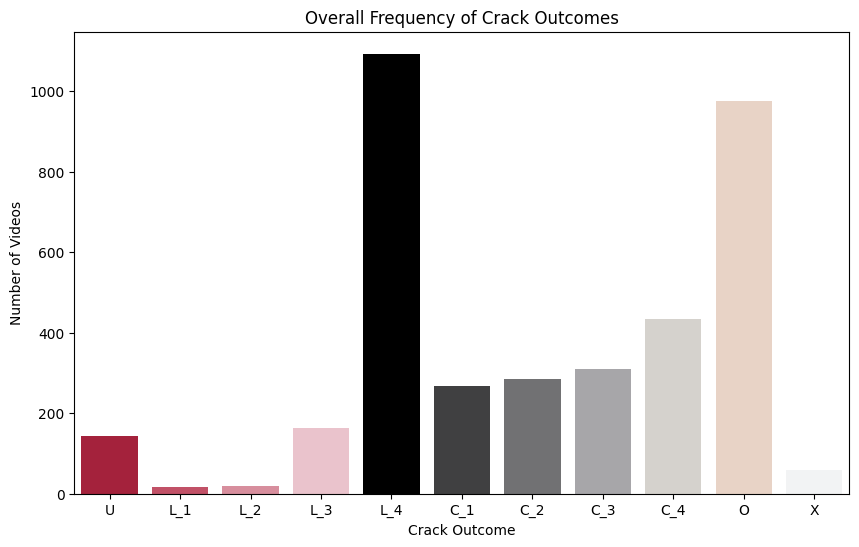

In [18]:
# Plot overall frequency with UGA palette
plt.figure(figsize=(10, 6))
sns.barplot(x=crack_outcome_cols, y=crack_counts[crack_outcome_cols].values, palette=uga_palette)  # x-axis categories  # y-axis heights  # custom color palette
plt.xlabel("Crack Outcome")
plt.ylabel("Number of Videos")
plt.title("Overall Frequency of Crack Outcomes")
plt.show()

In [19]:
# Define the 11 crack outcomes
crack_outcomes = ["U", "L_1", "L_2", "L_3", "L_4", "C_1", "C_2", "C_3", "C_4", "O", "X"]

# Define the 4 experimental factors
factors = ["moisture", "spring", "displacement", "motor"]

# Units / descriptive labels for axis labeling
factor_units = {"moisture": "Kernel Moisture (%)", "spring": "Spring Stiffness (N/mm)", "displacement": "Displacement Setting (in)", "motor": "Motor Speed (Hz)"}

outcome_labels = {"U": "Untouched", "L_1": "Longitudinal <25%", "L_2": "Longitudinal 25–50%", "L_3": "Longitudinal 50–75%", "L_4": "Longitudinal >75%", "C_1": "Circumferential <25%", "C_2": "Circumferential 25–50%", "C_3": "Circumferential 50–75%", "C_4": "Circumferential >75%", "O": "Open Crack", "X": "Crushed"}


### Mean Crack Outcome Percentages by Kernel Moisture (%) ###

   moisture      U   L_1   L_2    L_3    L_4    C_1    C_2    C_3    C_4  \
0         5   8.54  0.42  0.21   9.79  80.62  15.83  21.88  21.88  31.67   
1         7   4.59  1.67  1.88  11.27  79.96  17.33  22.13  20.46  36.53   
2         9  16.56  1.24  1.66  13.04  66.87  22.57  15.32  22.15  22.36   

       O     X  
0  73.12  3.96  
1  73.70  3.55  
2  56.11  4.55  


,moisture,U,L_1,L_2,L_3,L_4,C_1,C_2,C_3,C_4,O,X
0,5,8.541667,0.416667,0.208333,9.791667,80.625000,15.833333,21.875000,21.875000,31.666667,73.125000,3.958333
1,7,4.592902,1.670146,1.878914,11.273486,79.958246,17.327766,22.129436,20.459290,36.534447,73.695198,3.549061
2,9,16.563147,1.242236,1.656315,13.043478,66.873706,22.567288,15.320911,22.153209,22.360248,56.107660,4.554865


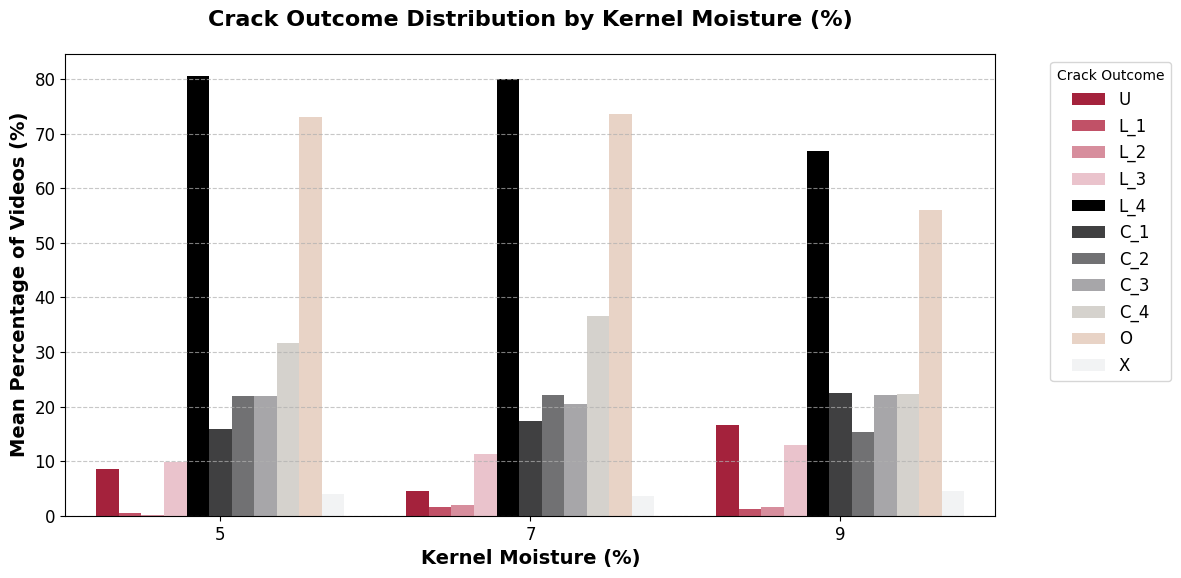


### Mean Crack Outcome Percentages by Spring Stiffness (N/mm) ###

   spring      U   L_1   L_2    L_3    L_4    C_1    C_2    C_3    C_4      O  \
0    1800  13.57  1.25  1.88   8.98  73.90  22.13  17.75  13.78  33.19  63.05   
1    2000  10.72  1.65  1.24  15.67  70.52  19.79  23.09  27.63  18.97  64.33   
2    2200   5.44  0.42  0.63   9.41  83.05  13.81  18.41  23.01  38.49  75.52   

      X  
0  4.80  
1  0.41  
2  6.90  


,spring,U,L_1,L_2,L_3,L_4,C_1,C_2,C_3,C_4,O,X
0,1800,13.569937,1.252610,1.878914,8.977035,73.903967,22.129436,17.745303,13.778706,33.194154,63.048017,4.801670
1,2000,10.721649,1.649485,1.237113,15.670103,70.515464,19.793814,23.092784,27.628866,18.969072,64.329897,0.412371
2,2200,5.439331,0.418410,0.627615,9.414226,83.054393,13.807531,18.410042,23.012552,38.493724,75.523013,6.903766


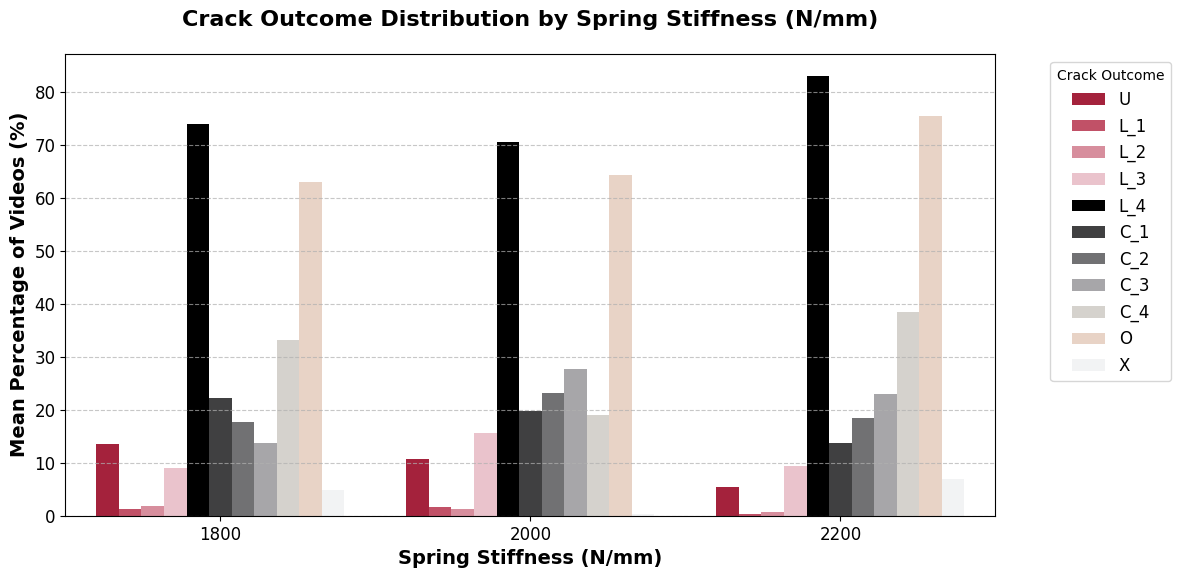


### Mean Crack Outcome Percentages by Displacement Setting (in) ###

   displacement      U   L_1   L_2    L_3    L_4    C_1    C_2    C_3    C_4  \
0          0.22   3.12  0.62  0.62   2.29  92.72   3.74   6.65  25.78  60.91   
1          0.29   5.39  0.83  1.45  11.20  80.29  12.66  31.54  30.71  19.71   
2          0.36  21.29  1.88  1.67  20.67  54.28  39.46  21.09   7.93   9.81   

       O     X  
0  90.23  4.57  
1  77.80  3.11  
2  34.66  4.38  


,displacement,U,L_1,L_2,L_3,L_4,C_1,C_2,C_3,C_4,O,X
0,0.22,3.118503,0.623701,0.623701,2.286902,92.723493,3.742204,6.652807,25.779626,60.914761,90.228690,4.573805
1,0.29,5.394191,0.829876,1.452282,11.203320,80.290456,12.655602,31.535270,30.705394,19.709544,77.800830,3.112033
2,0.36,21.294363,1.878914,1.670146,20.668058,54.279749,39.457203,21.085595,7.933194,9.812109,34.655532,4.384134


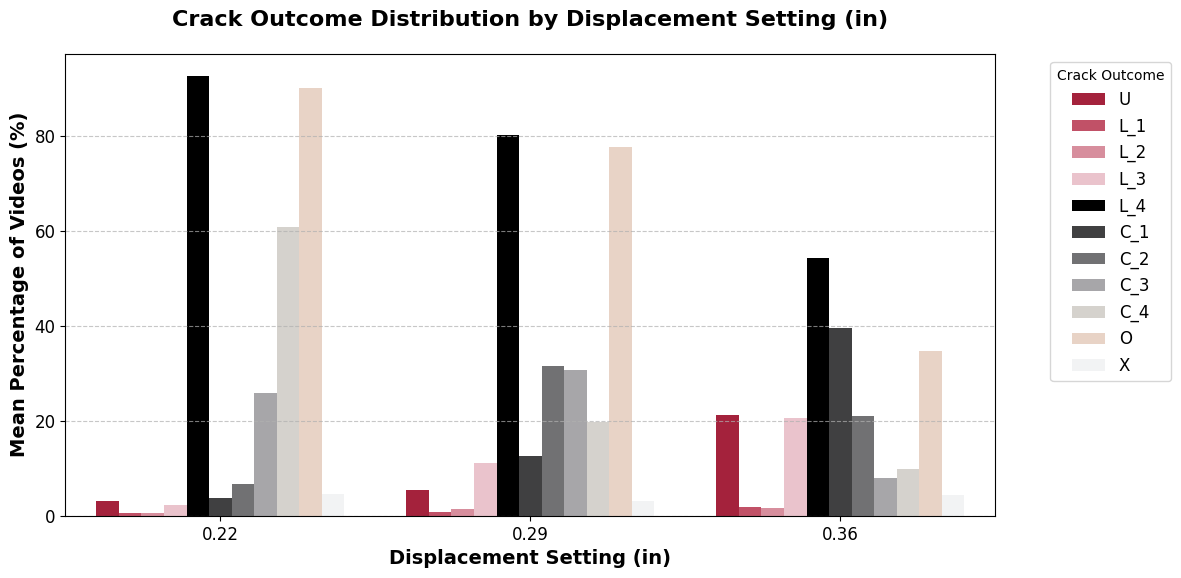


### Mean Crack Outcome Percentages by Motor Speed (Hz) ###

   motor      U   L_1   L_2    L_3    L_4    C_1    C_2    C_3    C_4      O  \
0     30   7.53  1.51  1.94  12.47  75.91  19.14  20.86  22.37  29.68  69.89   
1     45  13.31  0.81  1.01  11.90  71.98  21.37  17.54  18.35  29.44  60.89   
2     60   8.73  1.04  0.83   9.77  79.63  15.18  21.00  23.91  31.39  72.35   

      X  
0  3.23  
1  4.84  
2  3.95  


,motor,U,L_1,L_2,L_3,L_4,C_1,C_2,C_3,C_4,O,X
0,30,7.526882,1.505376,1.935484,12.473118,75.913978,19.139785,20.860215,22.365591,29.677419,69.892473,3.225806
1,45,13.306452,0.806452,1.008065,11.895161,71.975806,21.370968,17.540323,18.346774,29.435484,60.887097,4.838710
2,60,8.731809,1.039501,0.831601,9.771310,79.625780,15.176715,20.997921,23.908524,31.392931,72.349272,3.950104


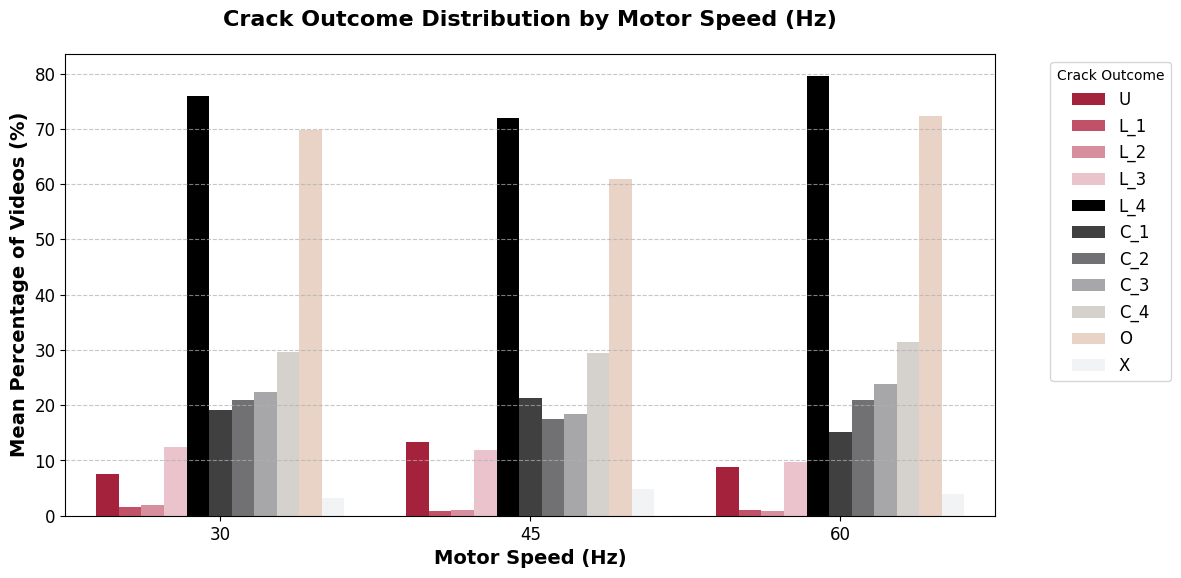

In [20]:
# 1) Group-Wise Summaries for All Factors
# We compute mean(=proportion) * 100 for each crack outcome by each factor's levels.


# Define a function for grouped bar plots
def plot_crack_outcomes_by_factor(df, factor):
    # Compute mean percentages
    grouped_factor = df.groupby(factor)[crack_outcomes].mean() * 100
    df_factor_reset = grouped_factor.reset_index()

    # Print exact percentages in table format
    print(f"\n### Mean Crack Outcome Percentages by {factor_units.get(factor, factor)} ###\n")
    print(df_factor_reset.round(2))  # Print the table
    display(df_factor_reset)

    # Convert from wide to long format for Seaborn
    factor_melted = pd.melt(df_factor_reset, id_vars=factor, value_vars=crack_outcomes, var_name="crack_outcome", value_name="percentage")

    # Create figure
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=factor, y="percentage", hue="crack_outcome", data=factor_melted, palette=uga_palette, hue_order=crack_outcomes)

    # Add labels with units if available
    xlabel = factor_units.get(factor, factor)
    ylabel = "Mean Percentage of Videos (%)"  # Standardized Y-axis

    plt.xlabel(xlabel, fontsize=14, fontweight="bold")
    plt.ylabel(ylabel, fontsize=14, fontweight="bold")

    # Enhance title
    plt.title(f"Crack Outcome Distribution by {xlabel}", fontsize=16, fontweight="bold", pad=20)

    # Improve legend placement
    plt.legend(title="Crack Outcome", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)

    # Improve tick label size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Show grid for readability
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


# Generate professional plots for each experimental factor
for factor in factors:
    plot_crack_outcomes_by_factor(df_agg, factor)

In [21]:
# Create folders to store plots
os.makedirs("plots_single_factor", exist_ok=True)
os.makedirs("plots_pair_factors", exist_ok=True)
os.makedirs("plots_triple_factors", exist_ok=True)
os.makedirs("plots_quad_factors", exist_ok=True)

In [22]:
# Define helper functions for labeling subplots and generating safe titles and x-labels for plots
def label_subplot(ax, index, x_offset=-0.15, y_offset=1.10):
    label = f"({chr(97 + index)})"  # ASCII 97='a', 98='b', etc.
    ax.text(x_offset, y_offset, label, transform=ax.transAxes, fontsize=12, fontweight="bold", ha="left", va="top")


def safe_title(fA, fB=None, fC=None, fD=None):
    if fB is None:
        return f"{factor_units[fA]}"
    elif fC is None:
        return f"{factor_units[fA]} & {factor_units[fB]}"
    elif fD is None:
        return f"{factor_units[fA]}, {factor_units[fB]}, {factor_units[fC]}"
    else:
        return f"{factor_units[fA]}, {factor_units[fB]}, {factor_units[fC]}, {factor_units[fD]}"


def safe_xlabel(*factors_in):
    return "(" + ", ".join(factor_units[f] for f in factors_in) + ")"

In [23]:
# Single-Factor Subplots for All 11 Outcomes
def plot_single_factor_subplots(df, factor_col, outcomes, palette=uga_palette):
    n_outcomes = len(outcomes)
    nrows = (n_outcomes + 3) // 4  # 4 subplots per row
    ncols = 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharey=False)
    axes = axes.flatten()

    for i, outcome in enumerate(outcomes):
        ax = axes[i]
        grouped_vals = df.groupby(factor_col)[outcome].mean() * 100
        df_reset = grouped_vals.reset_index().sort_values(by=factor_col)

        sns.barplot(x=factor_col, y=outcome, data=df_reset, palette=palette, ax=ax)

        # Add label OUTSIDE the plot
        label_subplot(ax, i)  # Pass fig here

        ax.set_xlabel(factor_units.get(factor_col, factor_col))
        ax.set_ylabel(f"% {outcome_labels.get(outcome, outcome)}")
        ax.set_ylim(0, 105)

    # Hide unused subplots
    total_subplots = nrows * ncols
    if n_outcomes < total_subplots:
        for j in range(n_outcomes, total_subplots):
            fig.delaxes(axes[j])

    # Main title and layout
    fig.suptitle(f"Figure: All Crack Outcomes vs. {factor_units.get(factor_col, factor_col)}", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

    fig.savefig(f"plots_single_factor/{factor_col}_all_outcomes.png", dpi=150)
    plt.close(fig)


# Generate subplots for each single factor
for fcol in factors:
    plot_single_factor_subplots(df_agg, fcol, crack_outcomes, uga_palette)

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\447479529.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\447479529.py:14: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.barplot(x=factor_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\447479529.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\447479529.py:14: UserWarning: The palette list

In [24]:
# Pairwise-Factor Subplots
pairwise_combos = [("moisture", "spring"), ("moisture", "displacement"), ("moisture", "motor"), ("spring", "displacement"), ("spring", "motor"), ("displacement", "motor")]


def plot_pairwise_subplots(df, fA, fB, outcomes, palette=uga_palette):
    combo_col = f"{fA}_{fB}"
    # Build the composite factor
    df[combo_col] = df[fA].astype(str) + "_" + df[fB].astype(str)

    n_outcomes = len(outcomes)
    nrows = (n_outcomes + 3) // 4
    ncols = 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharey=False)
    axes = axes.flatten()

    for i, outcome in enumerate(outcomes):
        ax = axes[i]
        grouped_vals = df.groupby(combo_col)[outcome].mean() * 100
        df_reset = grouped_vals.reset_index().sort_values(by=combo_col)

        sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
        label_subplot(ax, i)
        ax.set_xlabel(safe_xlabel(fA, fB))
        ax.set_ylabel(f"% {outcome_labels.get(outcome, outcome)}")
        ax.set_ylim(0, 105)
        ax.set_title(f"{outcome_labels.get(outcome, outcome)}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)

    if n_outcomes < len(axes):
        for j in range(n_outcomes, len(axes)):
            fig.delaxes(axes[j])

    fig.suptitle(f"Figure: All Outcomes vs. {safe_title(fA, fB)}", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # Save figure
    outname = f"{fA}_{fB}_all_outcomes.png"
    fig.savefig(os.path.join("plots_pair_factors", outname), dpi=150)
    plt.close(fig)

    # remove composite col
    df.drop(columns=[combo_col], inplace=True)


for fA, fB in pairwise_combos:
    plot_pairwise_subplots(df_agg, fA, fB, crack_outcomes, uga_palette)

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\662386980.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\662386980.py:21: UserWarning: The palette list has more values (11) than needed (9), which may not be intended.
  sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\662386980.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\662386980.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be

In [25]:
# Triple-Factor Subplots
triple_combos = [("moisture", "spring", "displacement"), ("moisture", "spring", "motor"), ("moisture", "displacement", "motor"), ("spring", "displacement", "motor")]


def plot_triple_subplots(df, fA, fB, fC, outcomes, palette=uga_palette):
    combo_col = f"{fA}_{fB}_{fC}"
    df[combo_col] = df[fA].astype(str) + "_" + df[fB].astype(str) + "_" + df[fC].astype(str)

    n_outcomes = len(outcomes)
    nrows = (n_outcomes + 3) // 4
    ncols = 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharey=False)
    axes = axes.flatten()

    for i, outcome in enumerate(outcomes):
        ax = axes[i]
        grouped_vals = df.groupby(combo_col)[outcome].mean() * 100
        df_reset = grouped_vals.reset_index().sort_values(by=combo_col)

        sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
        label_subplot(ax, i)
        ax.set_xlabel(safe_xlabel(fA, fB, fC))
        ax.set_ylabel(f"% {outcome_labels.get(outcome, outcome)}")
        ax.set_ylim(0, 105)
        ax.set_title(f"{outcome_labels.get(outcome, outcome)}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha="right", fontsize=7)

    if n_outcomes < len(axes):
        for j in range(n_outcomes, len(axes)):
            fig.delaxes(axes[j])

    fig.suptitle(f"Figure: All Outcomes vs. {safe_title(fA, fB, fC)}", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    outname = f"{fA}_{fB}_{fC}_all_outcomes.png"
    fig.savefig(os.path.join("plots_triple_factors", outname), dpi=150)
    plt.close(fig)

    df.drop(columns=[combo_col], inplace=True)


for a, b, c in triple_combos:
    plot_triple_subplots(df_agg, a, b, c, crack_outcomes, uga_palette)

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\576823774.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\576823774.py:20: UserWarning: 
The palette list has fewer values (11) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\576823774.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha="right", fontsize=7)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\576823774.py:20: FutureWarning: 

Passing `palette` without assigni

In [26]:
# Quadruple-Factor Subplots
quad_factors = ("moisture", "spring", "displacement", "motor")


def plot_quad_subplots(df, fA, fB, fC, fD, outcomes, palette=uga_palette):
    combo_col = f"{fA}_{fB}_{fC}_{fD}"
    df[combo_col] = df[fA].astype(str) + "_" + df[fB].astype(str) + "_" + df[fC].astype(str) + "_" + df[fD].astype(str)

    n_outcomes = len(outcomes)
    nrows = (n_outcomes + 3) // 4
    ncols = 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharey=False)
    axes = axes.flatten()

    for i, outcome in enumerate(outcomes):
        ax = axes[i]
        grouped_vals = df.groupby(combo_col)[outcome].mean() * 100
        df_reset = grouped_vals.reset_index().sort_values(by=combo_col)

        sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
        label_subplot(ax, i)
        ax.set_xlabel(safe_xlabel(fA, fB, fC, fD))
        ax.set_ylabel(f"% {outcome_labels.get(outcome, outcome)}")
        ax.set_ylim(0, 105)
        ax.set_title(f"{outcome_labels.get(outcome, outcome)}")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right", fontsize=6)

    if n_outcomes < len(axes):
        for j in range(n_outcomes, len(axes)):
            fig.delaxes(axes[j])

    fig.suptitle(f"Figure: All Outcomes vs. {safe_title(fA, fB, fC, fD)}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    outname = f"{fA}_{fB}_{fC}_{fD}_all_outcomes.png"
    fig.savefig(os.path.join("plots_quad_factors", outname), dpi=150)
    plt.close(fig)

    df.drop(columns=[combo_col], inplace=True)


plot_quad_subplots(df_agg, quad_factors[0], quad_factors[1], quad_factors[2], quad_factors[3], crack_outcomes)

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4004724732.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4004724732.py:20: UserWarning: 
The palette list has fewer values (11) than needed (81) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=combo_col, y=outcome, data=df_reset, palette=palette, ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4004724732.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right", fontsize=6)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4004724732.py:20: FutureWarning: 

Passing `palette` without ass

In [27]:
# Prepare Data for Regression Modeling
# Set global plotting style and context for publication-quality figures
sns.set(style="whitegrid")
sns.set_context("talk", font_scale=0.9)

# Load the final aggregated binary dataset (already cleaned and renamed)
df_agg = pd.read_csv("meyer_aggregated_binary_renamed.csv")
print("Aggregated binary dataset shape:", df_agg.shape)
df_agg.head()

# Ensure that factor columns are set as categorical.
# For clarity in modeling:
for col in ["moisture", "spring", "displacement", "motor"]:
    df_agg[col] = df_agg[col].astype("category")

# Display the unique levels for each factor (include units in comments):
print("Unique moisture levels (Kernel Moisture in %):", df_agg["moisture"].unique())
print("Unique spring stiffness levels (N/mm):", df_agg["spring"].unique())
print("Unique displacement settings (in):", df_agg["displacement"].unique())
print("Unique motor speed levels (Hz):", df_agg["motor"].unique())

Aggregated binary dataset shape: (1442, 16)
Unique moisture levels (Kernel Moisture in %): [7, 9, 5]
Categories (3, int64): [5, 7, 9]
Unique spring stiffness levels (N/mm): [2000, 1800, 2200]
Categories (3, int64): [1800, 2000, 2200]
Unique displacement settings (in): [0.22, 0.29, 0.36]
Categories (3, float64): [0.22, 0.29, 0.36]
Unique motor speed levels (Hz): [30, 45, 60]
Categories (3, int64): [30, 45, 60]


In [28]:
# Define the List of Outcomes and Run Logistic Regression Models
# List of crack outcomes (using our desired abbreviations)
crack_outcomes = ["U", "L_1", "L_2", "L_3", "L_4", "C_1", "C_2", "C_3", "C_4", "O", "X"]

# Dictionary to store the logistic regression models for later reference
logistic_models = {}

# Loop over each crack outcome and fit a logistic regression model
for outcome in crack_outcomes:
    # Ensure the outcome column is numeric (should be 0/1)
    df_agg[outcome] = pd.to_numeric(df_agg[outcome], errors="coerce")

    # Build the logistic regression formula. We use the C() function to treat factors as categorical.
    formula = f"{outcome} ~ C(moisture) + C(spring) + C(displacement) + C(motor)"

    # Fit the model using Generalized Linear Model (GLM) with a binomial family (logistic regression)
    model = smf.glm(formula=formula, data=df_agg, family=sm.families.Binomial()).fit()

    # Store the model in the dictionary
    logistic_models[outcome] = model

    # Print a header and the model summary
    print(f"\n--- Logistic Regression for Outcome '{outcome}' ---")
    print(model.summary())

    # Calculate and print the odds ratios (exponentiated coefficients)
    odds_ratios = np.exp(model.params)
    print("Odds Ratios:")
    print(odds_ratios)
    print("\n" + "-" * 80 + "\n")


--- Logistic Regression for Outcome 'U' ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      U   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Mon, 10 Mar 2025   Deviance:                       759.29
Time:                        23:23:00   Pearson chi2:                 1.15e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [29]:
# Model Validation and Effect Plots
# Load the final aggregated binary dataset

# 1) Load the final aggregated binary dataset
df_agg = pd.read_csv("meyer_aggregated_binary_renamed.csv")
print("Aggregated binary dataset shape:", df_agg.shape)

# 2) We have four factors
factors = ["moisture", "spring", "displacement", "motor"]

# Convert factor columns to string to avoid any mismatch issues with statsmodels
for f in factors:
    df_agg[f] = df_agg[f].astype(str)

# 3) Define crack outcomes (short codes) and descriptive labels
crack_outcomes = ["U", "L_1", "L_2", "L_3", "L_4", "C_1", "C_2", "C_3", "C_4", "O", "X"]
outcome_labels = {"U": "Untouched", "L_1": "Longitudinal <25%", "L_2": "Longitudinal 25-50%", "L_3": "Longitudinal 50-75%", "L_4": "Longitudinal >75%", "C_1": "Circumferential <25%", "C_2": "Circumferential 25-50%", "C_3": "Circumferential 50-75%", "C_4": "Circumferential >75%", "O": "Open Crack", "X": "Crushed"}


# 4) Factor units for labeling
factor_units = {"moisture": "(%)", "spring": "(N/mm)", "displacement": "(inches)", "motor": "(Hz)"}

# 5) UGA-themed color palette (11 distinct colors)

contrasting_colors = ["#BA0C2F", "#000000", "#717074", "#F2F3F4"]  # deep red  # black  # mid gray  # optional light neutral (use if 4 levels)

uga_palette = sns.color_palette(["#BA0C2F", "#D43E5C", "#E38296", "#F0BDC9", "#000000", "#404041", "#717074", "#A7A6A9", "#D7D2CB", "#EED2C0", "#F2F3F4"], n_colors=11)  # deep red  # medium red/pink  # lighter red/pink  # very light red/pink  # black  # dark gray  # mid gray  # suwanee gray  # pillar gray  # brand neutral  # chapel bell (very light neutral)

# 6) Typical (reference) values for logistic predictions, if needed
typical_values = {"moisture": "7", "spring": "2000", "displacement": "0.29", "motor": "45"}

print("Data and settings loaded. Ready for grouped bar plotting.")

Aggregated binary dataset shape: (1442, 16)
Data and settings loaded. Ready for grouped bar plotting.


In [30]:
# Grouped Bar Plots (Single Factor) with Vertical Labels
# Create a folder to store grouped bar plots
os.makedirs("plots_grouped", exist_ok=True)


def plot_grouped_bar_for_factor(df, factor_col, outcomes, outcome_labels, factor_units, palette, folder="plots_grouped"):
    # 1) Group data by factor_col, compute mean(=proportion)*100 for each outcome
    grouped = df.groupby(factor_col)[outcomes].mean() * 100

    # 2) Reindex the columns in the order of 'outcomes' (ensures consistent order)
    grouped = grouped[outcomes]

    # 3) Transpose so that each row is an outcome, columns are factor levels
    df_plot = grouped.transpose()

    # 4) Sort factor levels numerically if possible
    sorted_levels = sorted(df_plot.columns, key=lambda x: float(x))
    df_plot = df_plot[sorted_levels]

    # 5) Rename the index to show descriptive outcome labels
    #    i.e., from 'U' -> 'Untouched', 'L_1' -> 'Longitudinal <25%', etc.
    df_plot.index = [outcome_labels.get(x, x) for x in df_plot.index]

    # 6) Create a figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # 7) Plot as a grouped bar
    #    We have each row (outcome) on the x-axis, each factor level as a separate bar
    df_plot.plot(kind="bar", width=0.8, ax=ax, color=contrasting_colors[: len(df_plot.columns)], rot=90)  # use as many colors as factor levels  # rotate x-labels vertically

    # 8) Aesthetics: set y-limit to 0-100
    ax.set_ylim(0, 100)
    ax.set_ylabel("Mean Percentage of Videos (%)")
    ax.set_xlabel("Crack Outcome")

    # 9) Title with factor name and units
    unit_label = factor_units.get(factor_col, "")
    ax.set_title(f"Crack Outcome Distribution by {factor_col.capitalize()} {unit_label}")

    # 10) Move legend outside
    ax.legend(title=f"{factor_col.capitalize()} {unit_label}", bbox_to_anchor=(1.05, 1), loc="upper left")

    # 11) Tight layout for neatness
    plt.tight_layout()

    # 12) Save the figure
    filename = f"{folder}/{factor_col}_grouped_bar.png"
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"[INFO] Saved grouped bar plot for factor '{factor_col}' -> {filename}")


# Generate grouped bar plots for each factor
for factor in factors:
    plot_grouped_bar_for_factor(df_agg, factor, crack_outcomes, outcome_labels, factor_units, uga_palette, folder="plots_grouped")

print("All grouped bar plots saved with vertical labels and full descriptive names.")

[INFO] Saved grouped bar plot for factor 'moisture' -> plots_grouped/moisture_grouped_bar.png
[INFO] Saved grouped bar plot for factor 'spring' -> plots_grouped/spring_grouped_bar.png
[INFO] Saved grouped bar plot for factor 'displacement' -> plots_grouped/displacement_grouped_bar.png
[INFO] Saved grouped bar plot for factor 'motor' -> plots_grouped/motor_grouped_bar.png
All grouped bar plots saved with vertical labels and full descriptive names.


In [31]:
# FIT LOGISTIC MODEL FOR EACH OUTCOME & HELPER FOR PREDICTIONS
def fit_logistic_model(df, outcome):
    formula = f"{outcome} ~ C(moisture) + C(spring) + C(displacement) + C(motor)"
    model = smf.glm(formula=formula, data=df, family=Binomial()).fit()
    print(f"\n[MODEL SUMMARY] Logistic Regression for Outcome '{outcome}' ({outcome_labels[outcome]}):")
    print(model.summary())
    return model

In [32]:
# SINGLE-FACTOR PREDICTED PROBABILITY SUBPLOTS
os.makedirs("plots_model_predictions", exist_ok=True)


def plot_single_factor_subplots(df, factor, outcomes, palette, typical, save_folder):
    n_outcomes = len(outcomes)
    ncols = 4  # up to 4 columns
    nrows = int(math.ceil(n_outcomes / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharey=False)
    axes = axes.flatten()

    # Sort factor levels numerically
    factor_levels = sorted(df[factor].unique(), key=lambda x: float(x))

    # For each outcome, fit a logistic model, predict vs. factor
    for i, outcome in enumerate(outcomes):
        ax = axes[i]
        # Fit model
        model = fit_logistic_model(df, outcome)

        # Build a small grid DataFrame that varies 'factor' but keeps others fixed
        grid_list = []
        for lev in factor_levels:
            row = typical.copy()
            row[factor] = lev
            grid_list.append(row)
        pred_df = pd.DataFrame(grid_list)

        # Predict
        pred_df["predicted_prob"] = model.predict(pred_df) * 100

        # Bar plot
        sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
        ax.set_xlabel(f"{factor.capitalize()} {factor_units[factor]}")
        ax.set_ylabel("Predicted Probability (%)")
        ax.set_ylim(0, 100)
        ax.set_title(f"{outcome_labels[outcome]}")

        # Subplot label: (a), (b), etc.
        ax.text(0.02, 0.90, f"({chr(97+i)})", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top")

    # Hide any extra axes if outcomes < nrows*ncols
    for j in range(n_outcomes, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Predicted Probabilities vs. {factor.capitalize()} ({factor_units[factor]})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    filename = f"{save_folder}/{factor}_single_factor_composite.png"
    plt.savefig(filename, dpi=150)
    plt.close()
    print(f"[INFO] Saved single-factor subplots for {factor} -> {filename}")


# Generate single-factor predicted-prob subplots for each factor
for factor in factors:
    print(f"\n=== Single-Factor Predicted Probability Subplots for Factor: {factor} ===")
    plot_single_factor_subplots(df_agg, factor, crack_outcomes, uga_palette, typical_values, save_folder="plots_model_predictions")


=== Single-Factor Predicted Probability Subplots for Factor: moisture ===

[MODEL SUMMARY] Logistic Regression for Outcome 'U' (Untouched):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      U   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Mon, 10 Mar 2025   Deviance:                       759.29
Time:                        23:23:09   Pearson chi2:                 1.15e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|  

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_1' (Longitudinal <25%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_1   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81.362
Date:                Mon, 10 Mar 2025   Deviance:                       162.72
Time:                        23:23:09   Pearson chi2:                 1.54e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.009069
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_2' (Longitudinal 25-50%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_2   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88.201
Date:                Mon, 10 Mar 2025   Deviance:                       176.40
Time:                        23:23:09   Pearson chi2:                 1.21e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.01184
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_3' (Longitudinal 50-75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_3   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -456.02
Date:                Mon, 10 Mar 2025   Deviance:                       912.04
Time:                        23:23:10   Pearson chi2:                 1.45e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.07319
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_4' (Longitudinal >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -658.81
Date:                Mon, 10 Mar 2025   Deviance:                       1317.6
Time:                        23:23:10   Pearson chi2:                 1.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1756
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_1' (Circumferential <25%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_1   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -565.61
Date:                Mon, 10 Mar 2025   Deviance:                       1131.2
Time:                        23:23:10   Pearson chi2:                 1.28e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1612
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_2' (Circumferential 25-50%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_2   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -655.94
Date:                Mon, 10 Mar 2025   Deviance:                       1311.9
Time:                        23:23:10   Pearson chi2:                 1.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08100
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_3' (Circumferential 50-75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_3   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -686.51
Date:                Mon, 10 Mar 2025   Deviance:                       1373.0
Time:                        23:23:11   Pearson chi2:                 1.48e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08496
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_4' (Circumferential >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -664.48
Date:                Mon, 10 Mar 2025   Deviance:                       1329.0
Time:                        23:23:11   Pearson chi2:                 1.55e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2613
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'X' (Crushed):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      X   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -223.36
Date:                Mon, 10 Mar 2025   Deviance:                       446.72
Time:                        23:23:11   Pearson chi2:                 1.40e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02713
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)


[INFO] Saved single-factor subplots for moisture -> plots_model_predictions/moisture_single_factor_composite.png

=== Single-Factor Predicted Probability Subplots for Factor: spring ===

[MODEL SUMMARY] Logistic Regression for Outcome 'U' (Untouched):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      U   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Mon, 10 Mar 2025   Deviance:                       759.29
Time:                        23:23:16   Pearson chi2:                 1.15e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobust

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_1' (Longitudinal <25%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_1   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81.362
Date:                Mon, 10 Mar 2025   Deviance:                       162.72
Time:                        23:23:17   Pearson chi2:                 1.54e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.009069
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_3' (Longitudinal 50-75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_3   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -456.02
Date:                Mon, 10 Mar 2025   Deviance:                       912.04
Time:                        23:23:17   Pearson chi2:                 1.45e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.07319
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_4' (Longitudinal >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -658.81
Date:                Mon, 10 Mar 2025   Deviance:                       1317.6
Time:                        23:23:17   Pearson chi2:                 1.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1756
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_1' (Circumferential <25%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_1   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -565.61
Date:                Mon, 10 Mar 2025   Deviance:                       1131.2
Time:                        23:23:18   Pearson chi2:                 1.28e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1612
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_2' (Circumferential 25-50%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_2   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -655.94
Date:                Mon, 10 Mar 2025   Deviance:                       1311.9
Time:                        23:23:18   Pearson chi2:                 1.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08100
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_3' (Circumferential 50-75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_3   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -686.51
Date:                Mon, 10 Mar 2025   Deviance:                       1373.0
Time:                        23:23:18   Pearson chi2:                 1.48e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08496
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_4' (Circumferential >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -664.48
Date:                Mon, 10 Mar 2025   Deviance:                       1329.0
Time:                        23:23:18   Pearson chi2:                 1.55e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2613
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'O' (Open Crack):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      O   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -664.53
Date:                Mon, 10 Mar 2025   Deviance:                       1329.1
Time:                        23:23:18   Pearson chi2:                 1.36e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2867
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'X' (Crushed):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      X   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -223.36
Date:                Mon, 10 Mar 2025   Deviance:                       446.72
Time:                        23:23:19   Pearson chi2:                 1.40e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02713
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)


[INFO] Saved single-factor subplots for spring -> plots_model_predictions/spring_single_factor_composite.png

=== Single-Factor Predicted Probability Subplots for Factor: displacement ===

[MODEL SUMMARY] Logistic Regression for Outcome 'U' (Untouched):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      U   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Mon, 10 Mar 2025   Deviance:                       759.29
Time:                        23:23:24   Pearson chi2:                 1.15e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobu

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_1' (Longitudinal <25%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_1   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81.362
Date:                Mon, 10 Mar 2025   Deviance:                       162.72
Time:                        23:23:24   Pearson chi2:                 1.54e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.009069
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_4' (Longitudinal >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -658.81
Date:                Mon, 10 Mar 2025   Deviance:                       1317.6
Time:                        23:23:24   Pearson chi2:                 1.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1756
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_1' (Circumferential <25%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_1   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -565.61
Date:                Mon, 10 Mar 2025   Deviance:                       1131.2
Time:                        23:23:25   Pearson chi2:                 1.28e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1612
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_2' (Circumferential 25-50%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_2   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -655.94
Date:                Mon, 10 Mar 2025   Deviance:                       1311.9
Time:                        23:23:25   Pearson chi2:                 1.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08100
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_3' (Circumferential 50-75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_3   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -686.51
Date:                Mon, 10 Mar 2025   Deviance:                       1373.0
Time:                        23:23:25   Pearson chi2:                 1.48e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08496
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_4' (Circumferential >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -664.48
Date:                Mon, 10 Mar 2025   Deviance:                       1329.0
Time:                        23:23:25   Pearson chi2:                 1.55e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2613
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'O' (Open Crack):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      O   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -664.53
Date:                Mon, 10 Mar 2025   Deviance:                       1329.1
Time:                        23:23:26   Pearson chi2:                 1.36e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2867
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)


[INFO] Saved single-factor subplots for displacement -> plots_model_predictions/displacement_single_factor_composite.png

=== Single-Factor Predicted Probability Subplots for Factor: motor ===

[MODEL SUMMARY] Logistic Regression for Outcome 'U' (Untouched):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      U   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Mon, 10 Mar 2025   Deviance:                       759.29
Time:                        23:23:30   Pearson chi2:                 1.15e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            no

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_2' (Longitudinal 25-50%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_2   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88.201
Date:                Mon, 10 Mar 2025   Deviance:                       176.40
Time:                        23:23:31   Pearson chi2:                 1.21e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.01184
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_3' (Longitudinal 50-75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_3   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -456.02
Date:                Mon, 10 Mar 2025   Deviance:                       912.04
Time:                        23:23:31   Pearson chi2:                 1.45e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.07319
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)
C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'L_4' (Longitudinal >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    L_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -658.81
Date:                Mon, 10 Mar 2025   Deviance:                       1317.6
Time:                        23:23:31   Pearson chi2:                 1.35e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1756
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_2' (Circumferential 25-50%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_2   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -655.94
Date:                Mon, 10 Mar 2025   Deviance:                       1311.9
Time:                        23:23:32   Pearson chi2:                 1.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08100
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_3' (Circumferential 50-75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_3   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -686.51
Date:                Mon, 10 Mar 2025   Deviance:                       1373.0
Time:                        23:23:32   Pearson chi2:                 1.48e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08496
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'C_4' (Circumferential >75%):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    C_4   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -664.48
Date:                Mon, 10 Mar 2025   Deviance:                       1329.0
Time:                        23:23:32   Pearson chi2:                 1.55e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2613
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'O' (Open Crack):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      O   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -664.53
Date:                Mon, 10 Mar 2025   Deviance:                       1329.1
Time:                        23:23:32   Pearson chi2:                 1.36e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2867
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)



[MODEL SUMMARY] Logistic Regression for Outcome 'X' (Crushed):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      X   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -223.36
Date:                Mon, 10 Mar 2025   Deviance:                       446.72
Time:                        23:23:33   Pearson chi2:                 1.40e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02713
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

C:\Users\nr77309\AppData\Local\Temp\ipykernel_44216\4016079882.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor, y="predicted_prob", data=pred_df, palette=palette[: len(factor_levels)], ax=ax)


[INFO] Saved single-factor subplots for motor -> plots_model_predictions/motor_single_factor_composite.png


In [33]:
# PAIRWISE INTERACTION HEATMAPS (Multi-subplot)
os.makedirs("plots_interaction_effects", exist_ok=True)

pairwise_combos = [("moisture", "spring"), ("moisture", "displacement"), ("moisture", "motor"), ("spring", "displacement"), ("spring", "motor"), ("displacement", "motor")]


def plot_pairwise_interaction_subplots(df, factorA, factorB, outcomes, typical, palette, folder):
    n_outcomes = len(outcomes)
    ncols = 3
    nrows = int(math.ceil(n_outcomes / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows))
    axes = axes.flatten()

    # Sort factor levels
    levelsA = sorted(df[factorA].unique(), key=lambda x: float(x))
    levelsB = sorted(df[factorB].unique(), key=lambda x: float(x))

    for i, outcome in enumerate(outcomes):
        ax = axes[i]
        # Fit logistic model
        model = fit_logistic_model(df, outcome)

        # Build grid
        grid_list = []
        for alev in levelsA:
            for blev in levelsB:
                row = typical.copy()
                row[factorA] = alev
                row[factorB] = blev
                grid_list.append(row)
        pred_df = pd.DataFrame(grid_list)
        pred_df["predicted_prob"] = model.predict(pred_df) * 100

        # Pivot for heatmap
        pivot_table = pred_df.pivot(index=factorA, columns=factorB, values="predicted_prob")
        sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="Reds", cbar=False, ax=ax)  # you can set cbar=True if you want a colorbar in each subplot
        ax.set_xlabel(f"{factorB.capitalize()} {factor_units[factorB]}")
        ax.set_ylabel(f"{factorA.capitalize()} {factor_units[factorA]}")
        ax.set_title(f"{outcome_labels[outcome]}")

        # subplot label
        ax.text(0.02, 0.92, f"({chr(97+i)})", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top")

    # Hide extra axes if needed
    for j in range(n_outcomes, len(axes)):
        fig.delaxes(axes[j])

    # Global title
    fig.suptitle(f"Pairwise Interaction: {factorA.capitalize()} x {factorB.capitalize()}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    filename = f"{folder}/{factorA}_{factorB}_interaction_subplots.png"
    plt.savefig(filename, dpi=150)
    plt.close()
    print(f"[INFO] Saved pairwise interaction subplots for ({factorA}, {factorB}) -> {filename}")


# Generate pairwise interaction subplots for each pair
for fA, fB in pairwise_combos:
    print(f"\n=== Pairwise Interaction Subplots for: ({fA}, {fB}) ===")
    plot_pairwise_interaction_subplots(df_agg, fA, fB, crack_outcomes, typical_values, uga_palette, folder="plots_interaction_effects")

print("\nAll steps completed. Check the 'plots_grouped', 'plots_model_predictions', and 'plots_interaction_effects' folders for outputs.")


=== Pairwise Interaction Subplots for: (moisture, spring) ===

[MODEL SUMMARY] Logistic Regression for Outcome 'U' (Untouched):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      U   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Mon, 10 Mar 2025   Deviance:                       759.29
Time:                        23:23:37   Pearson chi2:                 1.15e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025  

In [34]:
# Single Figure per Outcome with All Pairwise Interactions
def plot_all_pairs_for_one_outcome(df, outcome, pairwise_combos, typical, palette, folder="plots_interaction_effects"):
    # Fit logistic model once for this outcome
    model = fit_logistic_model(df, outcome)

    n_pairs = len(pairwise_combos)  # should be 6
    ncols = 3
    nrows = int(math.ceil(n_pairs / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3.5 * nrows))
    axes = axes.flatten()

    for i, (factorA, factorB) in enumerate(pairwise_combos):
        ax = axes[i]

        # Sort factor levels (as strings, but numeric)
        levelsA = sorted(df[factorA].unique(), key=lambda x: float(x))
        levelsB = sorted(df[factorB].unique(), key=lambda x: float(x))

        # Build a grid of typical values
        grid_list = []
        for alev in levelsA:
            for blev in levelsB:
                row = typical.copy()
                row[factorA] = alev
                row[factorB] = blev
                grid_list.append(row)
        pred_df = pd.DataFrame(grid_list)

        # Predict logistic model
        pred_df["predicted_prob"] = model.predict(pred_df) * 100

        # Pivot for heatmap
        pivot_table = pred_df.pivot(index=factorA, columns=factorB, values="predicted_prob")

        # Create heatmap
        sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="Reds", cbar=False, ax=ax)
        ax.set_xlabel(f"{factorB.capitalize()} {factor_units[factorB]}")
        ax.set_ylabel(f"{factorA.capitalize()} {factor_units[factorA]}")
        ax.set_title(f"{factorA.capitalize()} x {factorB.capitalize()}")

        # Label each subplot (a), (b), ...
        ax.text(0.02, 0.92, f"({chr(97+i)})", transform=ax.transAxes, fontsize=12, fontweight="bold", va="top")

    # Hide any unused axes if pairwise_combos < len(axes)
    for j in range(n_pairs, len(axes)):
        fig.delaxes(axes[j])

    # Global title for the entire figure
    fig.suptitle(f"All Pairwise Interactions for {outcome_labels[outcome]}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    filename = f"{folder}/all_pairs_{outcome}.png"
    plt.savefig(filename, dpi=150)
    plt.close()
    print(f"[INFO] Saved multi-subplot figure of all pairwise combos for outcome '{outcome}' -> {filename}")


# Now, if you want to produce *one figure per outcome* (each containing 6 subplots):
for out in crack_outcomes:
    print(f"\n=== Creating multi-subplot figure for outcome: {out} ({outcome_labels[out]}) ===")
    plot_all_pairs_for_one_outcome(df=df_agg, outcome=out, pairwise_combos=pairwise_combos, typical=typical_values, palette=uga_palette, folder="plots_interaction_effects")

print("\n[INFO] Done generating one multi-subplot figure per outcome with all pairwise heatmaps.")


=== Creating multi-subplot figure for outcome: U (Untouched) ===

[MODEL SUMMARY] Logistic Regression for Outcome 'U' (Untouched):
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      U   No. Observations:                 1442
Model:                            GLM   Df Residuals:                     1433
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.65
Date:                Mon, 10 Mar 2025   Deviance:                       759.29
Time:                        23:25:17   Pearson chi2:                 1.15e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1130
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.02